# Introduction to the BAREFOOT Framework
## A Bayesian Optimization Framework for Optimization of Multi-Fidelity Models

### 2) A brief introduction to the Batch Bayesian Optimization approach implemented in BAREFOOT

Traditionally, Bayesian Optimization is done sequentially. We'll consider this sequential approach first and then demonstrate how the approach is modified when we implement the Batch Bayesian Optimization approach. First, some necessary imports.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pickle import dump, load
from mechModels import RVE_GP
from gpModel import gp_model
from pyDOE import lhs
from copy import deepcopy

For this we will use the egg-holder function (formulated to be a maximization problem rather than the conventional minimization)

$$ f(x) = (x_2+47)\text{sin}\left(\sqrt{\left|x_2 + \frac{x_1}{2} + 47\right|}\right) + x_1 \text{sin} \left(\sqrt{\left|x_1-(x_2+47)\right|}\right)$$

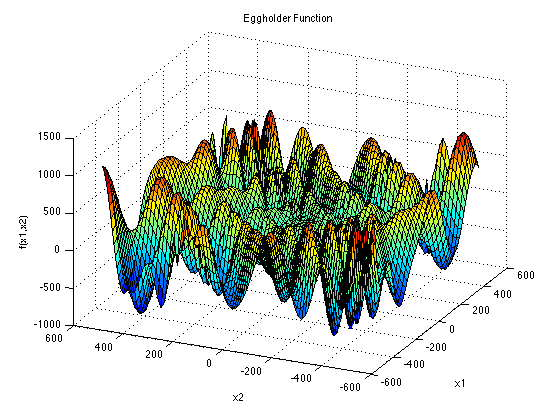

This function will have a maximum of $f(x^*)=959.6407$ at $x^*=(512,404.2319)$. The input range for the function is $x_i \in [-512,512]$. The code for the function is shown below.



In [ ]:
def eggholder(x):
    if len(x.shape) == 1: # If the input is a single point, it might only have a single dimension. This corrects that problem.
        x = np.expand_dims(x, axis=0)
    term1 = (x[:,1]+47) * np.sin(np.sqrt(np.abs(x[:,1]+x[:,0]/2+47)))
    term2 = x[:,0] * np.sin(np.sqrt(np.abs(x[:,0]-(x[:,1]+47))))
    return term1 + term2

Knowing where and what the maximum of the function is helps us to know whether the optimization is actually working correctly, however, in real applications we don't know what the true optimum is and only have access to evaluations from the 'function' that often have an error (or noise) associated with them. As such, we conduct the optimization under the assumption that we don't know anything about the function we are optimizing.

The first step is to obtain initial data. For the purposes of this demonstration, we will consider a single initial data point (as a side note on this, Bayesian Optimization appears to work better with less initial data). So let's define an initial value that is randomly placed in the design space and evaluate it from the eggholder function

In [ ]:
x_init = np.array([[np.random.randint(-512,512), np.random.randint(-512,512)]])
y_init = eggholder(x_init)

Now that we have the initial data, we need to construct a Gaussian Process model as a surrogate of the true function. This requires us to specify the hyperparameter of the Gaussian Process covariance function. This is tricky to do at the best of times, but we will get back to this point when we consider the batch optimization approach. Again, we'll use the gp_model class to create the GP model.

In [ ]:
gpModel = gp_model(x_init, y_init, [0.5,0.5], 10, 0.05, 2, "SE")

Now, we need to evaluate where we would like to query the model next (assuming that the function is very expensive to evaluate and I want to maximize the information I gain from each evalutation). To do this, we make use of an acquisition function (sometimes referred to as a utility function). There are many forms of these functions, but we will use one of the simpler and more commonly used ones. This acquisition function is called Expected Improvement \[2\] and an implementation of the approach is as follows:

$$ EI(x) = \Bigg\{ \begin{matrix} 
d\Phi(d/\sigma(x))+\sigma\phi(d/\sigma(x)) & \text{if } \sigma(x)>0\\
0 & \text{if } \sigma(x)=0\\
\end{matrix}$$

where $d=(y-y^{*}-\xi)$, $y^{*}$ is the current best objective value, $\Phi$ is the normal probability distribution function (pdf) and $\phi$ is the cumulative normal distribution function (cdf). In this acquisition function the $\xi$  parameter determines how explorative, or exploitative the optimization is. The suggested value is $\xi=0.01$ and will be used in this demonstration, but feel free to change this value to see how it affects the optimization result. The implementation of this acquisition function in Python is quite simple, and the function is below. This function will evaluate the Expected Improvement at all test points and then select which point has the maximum expected improvement.

In [ ]:
from scipy.stats import norm

def expectedImprovement(curr_max, xi, y, std):
    pdf = norm.pdf(y)
    cdf = norm.cdf(y)

    EI = (y-curr_max-xi)*pdf + std*cdf
        
    max_val = np.max(EI)
    x_star = np.where(EI == max_val)[0]
    
    return max_val, x_star[0], EI

So now that we have the Gaussian Process model, and the acquisition function we are in a position to perform the optimization. The steps of a Bayesian optimization are as follows:

1) Evaluate the surrogate model as extensively as possible

2) Calculate the acquisition function for each of the points evaluated from the surrogate

3) Determine which point has the maximum acquisition function value

4) Evaluate this point from the true function

5) Add this new information to the surrogate model (and retrain)

6) Repeat steps 1-5 until maximum found or resources expended


In [ ]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import time
from pyDOE import lhs

def pltsin(ax, x, y):
    if ax.lines:
        for line in ax.lines:
            line.set_xdata(x)
            line.set_ydata(y)
    else:
         ax.plot(x, y)
    fig.canvas.draw()

fig,ax = plt.subplots(1,1)
ax.set_xlabel('Iteration')
ax.set_ylabel('$G_t$')
ax.set_xlim(-1,100)
ax.set_ylim(-0.1,1.1)

gpModel = gp_model(x_init, y_init, [0.5,0.5], 10, 0.05, 2, "SE")

y_max = [0]
iteration = [-1]

for f in range(100):
    #x_test = lhs(2,200)*10-5
    x_test = lhs(2,200)*1024-512
    mean_test, var_test = gpModel.predict_var(x_test)
    max_val, x_star, EI = expectedImprovement(y_max[f], 0.01, mean_test, np.sqrt(var_test))
    new_y = eggholder(x_test[x_star])
    
    gpModel.update(x_test[x_star], new_y, 0.05, False)
    
    iteration.append(f)
    gap = (new_y-y_init)/(959.6407-y_init)
    
    if gap > y_max[f]:
        y_max.append(gap)
        
    else:
        y_max.append(y_max[f])
        
    
    pltsin(ax, iteration, y_max)
    
iteration_seq = deepcopy(iteration)
y_max_seq = deepcopy(y_max)

Here we are showing the result using the Gap Metric, which is a useful way to present the data since it shows all results on a scale from 0 to 1. 

$$ G_t = \frac{y^+ - y^*}{y^{max} - y^*} $$

where $y^*$ is the objective value from the initial data, and $y^+$ is the current maximum at iteration t. 

The results show that we are able to achieve some optimization of the value, and by running the calculation multiple times we can achieve better or worse results because the process is stochastic and so there is some "chance" involved in finding a solution quickly. The aim of finding better optimization approaches is to find a way to ensure that the chance the stochastic process will find the correct answer is greatly increased.

So how does the batch optimization approach differ? This approach is from work by Joy et al. \[1\] and is based on the premise that it is never really possible to know the true hyperparameter values for the GP surrogate model in the optimization. The main reason for this is that when the objective function is expensive enough, we are never able to obtain enough data to evaluate the hyperparameters either through monte-carlo based methods or gradient-based approaches. 

Therefore, if we don't have enough information to define the hyperparameters, is it reasonable to select a single value for each of the hyperparameters?

To avoid this conundrum, the batch approach proposed by Joy et al. samples hyperparameter values from a distribution and evaluates surrogate models constructed with all of these hyperparameter sets. In other words, we make no assumption on the shape of the underlying function by choosing a single set of hyperparameter values. This is demonstrated in the figure below.


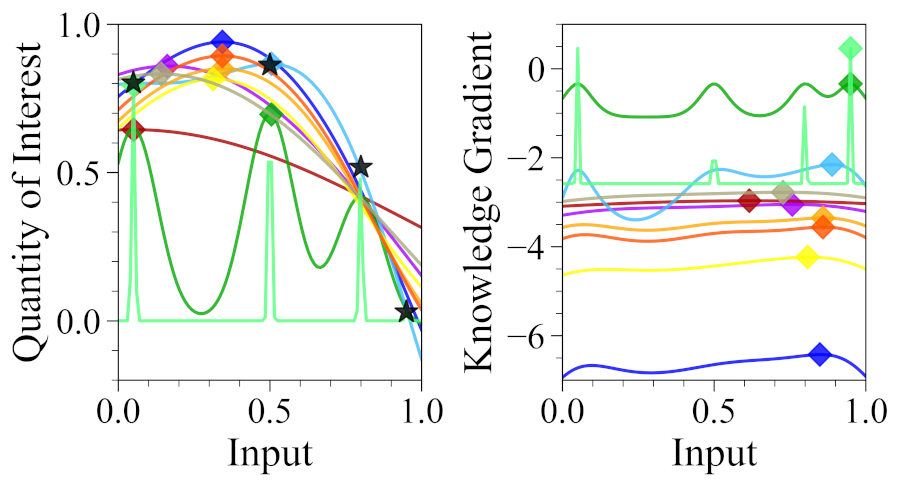

In this figure, we have several training points (stars), and GP means evaluated from GP models built with a variety of hyperparameter values. Each of these has slightly different shape, and as seen in part two of the figure, has different evaluations from an acquisition function (in this case Knowledge Gradient). Since each hyperparameter set produces a next best point to query, the question now becomes, how do we select which point to query?

There are probably several approaches that would answer this question, however, in the work by Joy et al. they chose to use a clustering approach called k-medoids to cluster the answers into the number of clusters required by the batch size. The code for the kMedoids approach was developed separately and is available from Github (https://github.com/SachinKalsi/kmedoids).

In [ ]:
from kmedoids import kMedoids
from scipy.spatial import distance_matrix

def k_medoids(sample, num_clusters):
    D = distance_matrix(sample, sample)
    M, C = kMedoids(D, num_clusters)
    return M, C  

So the first thing that we want to do is to set the hyperparameters. We can calculate these on each iteration, but that will increase computational time slightly, so we'll set the hyperparameters at the start of the optimization and not vary them after that. So the hyperparameters that we will vary are the characteristic length scale and the signal variance and we'll use 100 sets.

In [ ]:
sf_values = lhs(1,100)*10

L_values = np.linspace(0.001, 1.0, num=100, endpoint=True)

hp_sets = np.zeros((100,3))

for i in range(100):
    hp_sets[i,0] = sf_values[i]
    hp_sets[i,1] = L_values[np.random.randint(0,100)]
    hp_sets[i,2] = L_values[np.random.randint(0,100)]

Now we can run the Batch Bayesian Optimization. We follow an almost identical approach to that used in the sequential method. The changes between the traditional Bayesian Approach and the Batch Approach are shown in italics:

1) *Build the surrogate model using one of the hyperparameter sets*

2) Evaluate the surrogate model as extensively as possible

3) Calculate the acquisition function for each of the points evaluated from the surrogate

4) *Repeat steps 1-3 for each hyperparameter set*

5) *Cluster the results from steps 1-4 using k-medoids*

6) *Evaluate all these medoid points from the true function (evaluations done in parallel in practice)*

7) Add this new information to the surrogate model (and retrain)

8) Repeat steps 1-5 until maximum found or resources expended


In [ ]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import time
from pyDOE import lhs

def pltsin(ax, x, y):
    if ax.lines:
        ii = 0
        for line in ax.lines:
            line.set_xdata(x[ii])
            line.set_ydata(y[ii])
            ii += 1
    else:
        ax.plot(x[0], y[0], label="Batch")
        ax.plot(x[1], y[1], label="Sequential")
        ax.legend()
    fig.canvas.draw()

fig,ax = plt.subplots(1,1)
ax.set_xlabel('Iteration')
ax.set_ylabel('$G_t$')
ax.set_xlim(-1,100)
ax.set_ylim(-0.1,1.1)

gpModel = gp_model(x_init, y_init, [0.5,0.5], 10, 0.05, 2, "SE")

y_max = [0]
iteration = [-1]

for f in range(100):
    #x_test = lhs(2,200)*10-5
    x_test = lhs(2,200)*1024-512
    max_val_list = []
    for ii in range(100):
        gpModel.l_param = np.array([hp_sets[ii,1], hp_sets[ii,2]])
        gpModel.sigma_f = hp_sets[ii,0]
        gpModel.kk = gpModel.create_kernel()
        gpModel.gp = gpModel.create_gp()
        mean_test, var_test = gpModel.predict_var(x_test)
        max_val, x_star, EI = expectedImprovement(y_max[f], 0.01, mean_test, np.sqrt(var_test))
        max_val_list.append([max_val, x_star])
    
    medoids, clusters = k_medoids(np.array(max_val_list), 3)
    
    gap_min = 0
    
    for ii in range(3):
        new_y = eggholder(x_test[medoids[ii]])
        gpModel.update(x_test[medoids[ii]], new_y, 0.05, False)
        
        gap_new = (new_y-y_init)/(959.6407-y_init)
        if gap_new > gap:
            gap = gap_new
    
    if gap > y_max[f]:
        y_max.append(gap)
        
    else:
        y_max.append(y_max[f])
        
    iteration.append(f)
    pltsin(ax, [iteration, iteration_seq], [y_max, y_max_seq])

In most cases we should see that the Batch Bayesian Optimization performs better than the sequential optimization. However, since this is a stochastic process, there are some calculations that just struggle to optimize well for some reason. And so, while this approach is definitely an improvement over sequential Bayesian Optimization, there is still potential room for improvement.

### Comparison with Reification/Fusion Results for the Mechanical Model Problem

In the previous section we demonstrated the optimization of a set of mechanical models using only the Reification/Fusion approach. To recap, the aim was to optimize the normalized strain hardening rate $(1/\sigma(d\sigma/d\epsilon_{pl}))$ of a dual phase material using three reduced order models and a Finite Element Ground Truth Model. These models are shown again below

#### Reduced Order Models:
##### Isowork
The isowork model is a simple empirical model that assumes that the work is evenly distributed between the two phases of a material.

##### Isostrain
The isostrain model assumes thas the strain is distributed in an identical manner in the two phases

##### Isostress
The isostress model assumes that the stress is identical in both phases.

As can be seen in the figures below, each of these models provides a poor estimate of the Finite Element Model ground truth. 

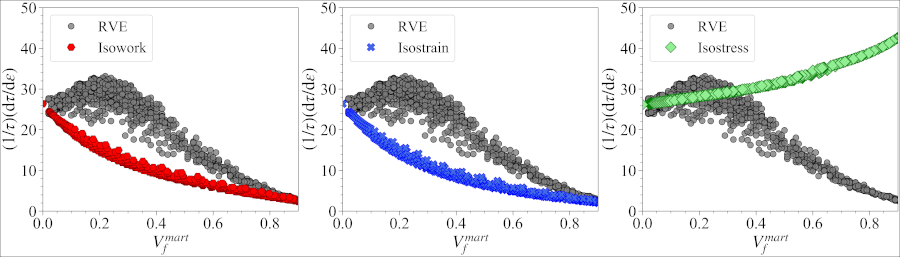

For the Batch Bayesian Optimization approach, we don't need the reduced order models at all. We will only use the RVE GP model. So we can create the RVE model, and we will use the same initial points that we used previously

In [ ]:
class RVE_GP():
    def __init__(self):
        self.mean = 0
        self.std = 0
        self.gp = 0
        self.setup()
        
    def setup(self):
        data = pd.read_excel('./data/rve_data.xlsx')
        data.iloc[:,0] = (data.iloc[:,0]-650)/200
        data.iloc[:,2] = data.iloc[:,2]/3
        data.iloc[:,3] = data.iloc[:,3]/2
        self.mean = np.mean(data.iloc[:,5])
        self.std = np.std(data.iloc[:,5])
        data.iloc[:,5] = (data.iloc[:,5]-self.mean)/self.std
        self.gp = gp_model(data.iloc[:,0:4], data.iloc[:,5], np.array([0.12274117, 0.08612411, 0.65729583, 0.23342798]), 0.16578065, 0.1, 4, 'SE')

    def predict(self, x_predict):
        if len(x_predict.shape) == 1:
            x_predict = np.expand_dims(x_predict, axis=0)
        x = np.ones((x_predict.shape[0],4))        
        x[:,0] = x_predict[:,0]           #Temperature
        x[:,1] = x_predict[:,1]           #wt% C
        x[:,2] = x[:,2]*0.283/2           #wt% Si
        x[:,3] = x[:,3]*0.328/3           #wt% Mn
        mean, var = self.gp.predict_var(x)
        
        return (mean*self.std + self.mean)

rve = RVE_GP() 
x_init = np.array([[0.9,0.9], [0.8,0.8]])

First step in the process is to evaluate the initial points from the RVE Model

In [ ]:
TMIn = x_init
TMOut = rve.predict(deepcopy(x_init))

And then we can create a GP model to fit this initial data and to update as we do more evaluations.

In [ ]:
rveGP = gp_model(x_init, TMOut, [0.1,0.1], 1, 0.05, 2, "SE")

For the batch optimization approach we need to define the hyperparameter sets to use. The approach below allows us to have values at several different levels. Our research indicates that having a lower limit as low as 0.0001 helps the optimization, and this is why we use such a low value.

In [ ]:
hp_set_options1 = np.linspace(0.0001, 0.001, 12, endpoint=False)
hp_set_options2 = np.linspace(0.001, 0.01, 12, endpoint=False)
hp_set_options3 = np.linspace(0.01, 0.1, 12, endpoint=False)
hp_set_options4 = np.linspace(0.1, 1, 14)

hp_set_options = np.concatenate([hp_set_options1,
                           hp_set_options2,
                           hp_set_options3,
                           hp_set_options4,])

To create the hyperparameter sets we randomly combine the values found above into sets.

In [ ]:
HP_Sets = []

for ii in range(100):
    HP_Sets.append([hp_set_options[np.random.randint(0,50)],
                    hp_set_options[np.random.randint(0,50)],
                    hp_set_options[np.random.randint(0,50)]])

Let's create some lists to keep track of the results

In [ ]:
max_RVE = [np.max(TMOut), np.max(TMOut)]
RVE_calls = [0,2]
ii = 0

And let's load the previous results so that we can compare the Batch Bayesian Optimization with the Reification/Fusion Optimization approach.

In [ ]:
with open("reificationOnlyResults.pickle", 'rb') as f:
    reifiOutput = load(f)

Again, this is a longer chunk of code to facilitate the plotting comparison and the loop for doing the optimization

In [ ]:
%matplotlib notebook
    
def pltsin(ax, x, y):
    if ax.lines:
        ii = 0
        for line in ax.lines:
            line.set_xdata(x[ii])
            line.set_ydata(y[ii])
            ii += 1
    else:
        ax.plot(x[0], y[0], label="Batch Bayesian")
        ax.plot(x[1], y[1], label="Reification/Fusion")
        ax.legend()
    fig.canvas.draw()

fig,ax = plt.subplots(1,1)
ax.set_xlabel('RVE Evaluations')
ax.set_ylabel('$1/\sigma(d\sigma/d\epsilon_{pl})$')
ax.set_xlim(0,20)
ax.set_xticks([0,2,4,6,8,10,12,14,16,18,20])
ax.set_ylim(0,35)

for ii in range(4):
    
    x_test = lhs(2,20)

    outputs = np.zeros((50,2))

    for jj in range(50):
        rveGP.l_param = np.array([HP_Sets[jj][1], HP_Sets[jj][2]])
        rveGP.sigma_f = HP_Sets[jj][0]*15
        rveGP.kk = rveGP.create_kernel()
        rveGP.gp = rveGP.create_gp()
        mean_test, var_test = rveGP.predict_var(deepcopy(x_test))
        max_val, x_star, EI = expectedImprovement(max_RVE[ii], 0.01, mean_test, np.sqrt(var_test))
        outputs[jj,0] = max_val
        outputs[jj,1] = x_star
    try:
        medoids, clusters = k_medoids(np.array(outputs), 5)
    except:
        try:
            medoids, clusters = k_medoids(np.array(outputs), 3)
        except:
            medoids, clusters = k_medoids(np.array(outputs), 1)

    max_new = -1

    for jj in range(len(medoids)):
        x_eval = int(outputs[medoids[jj],1])
        new_y = rve.predict(deepcopy(x_test)[x_eval])
        rveGP.update(deepcopy(x_test)[x_eval], new_y, 0.05, False)
        if new_y[0] > max_new:
            max_new = new_y[0]
    if max_new > max_RVE[-1]:
        max_RVE.append(max_new)
    else:
        max_RVE.append(max_RVE[-1])
    RVE_calls.append(RVE_calls[-1]+len(medoids))
    
    pltsin(ax, [RVE_calls, reifiOutput[0]], [max_RVE, reifiOutput[1]])

The first comment that can be made is that the Batch Bayesian Optimzation approach is significantly faster than the Reification/Fusion approach. One of the main reasons is that the Batch Bayesian approach only requires 4 iterations with a batch size of 5 to reach 20 total evaluations from the RVE model.

Again, because I haven't fixed the random seed, the results are likely to vary. And so there is little that can be said by way of comparison using the results above. That said, one of the main objectives of developing new optimization approaches is to ensure that despite the stochastic nature of the process, the optimization method is always able to perform well. And so again I have calculated 30 iterations of the optimization and the mean and variance of these results are shown in comparison to the Reification/Fusion results from the previous notebook. As we can see, the batch approach takes slightly longer to optimize, but in the end has a slightly higher mean, and lower variance than the Reification/Fusion approach.

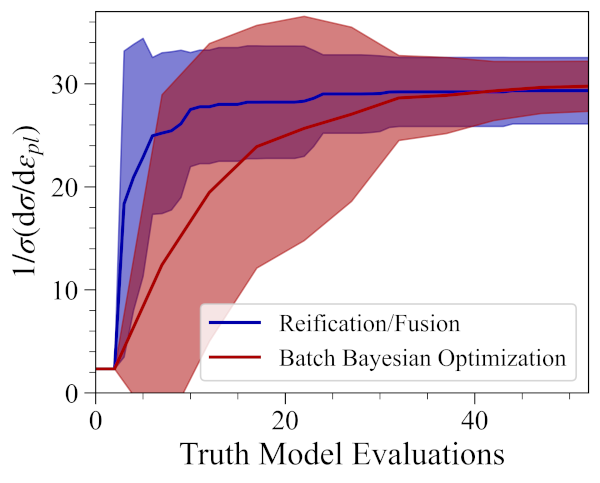

From these results, we can see that with the current settings, the Reification/Fusion approach outperforms the Batch Bayesian Optimzation approach by optimizing faster, however, the final result from the batch optimization has less variance, which would indicate slightly more robust performance. **_BUT_**, this isn't the best comparison. If we assume, for simplicity, that a single Truth Model Evaluation takes 1 day to complete, and make a further assumption that the batch of calculations used takes exactly the time required for a single calculation, it is possible to plot these optimization results in terms of the time for the optimization.

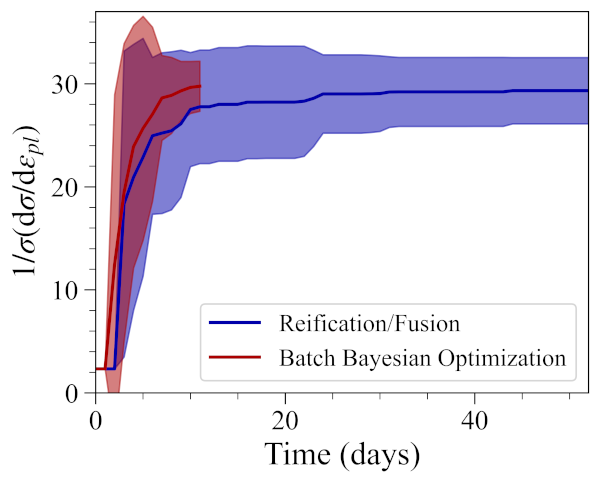

Now we can see the true advantage of the Batch approach. Where the sequential Reification/Fusion approach takes about **50** days to complete (under our assumption of 1 day for a Truth Model Query), the Batch Optimization is finished in about **10** days.

## References

\[1\] Joy, Tinu Theckel, Santu Rana, Sunil Gupta, and Svetha Venkatesh. “Batch Bayesian Optimization Using Multi-Scale Search.” Knowledge-Based Systems, June 27, 2019. https://doi.org/10.1016/j.knosys.2019.06.026.

\[2\] Močkus, J. “On Bayesian Methods for Seeking the Extremum.” In Optimization Techniques IFIP Technical Conference Novosibirsk, July 1–7, 1974, edited by G. I. Marchuk, 400–404. Berlin, Heidelberg: Springer Berlin Heidelberg, 1975.

